# Устанавливаем pytorch

## Linux/OSX


На оффсайте http://pytorch.org/ надо выбрать подходящую конфигурацию и скачать.

Версию python можно узнать в терминале:
```
python --version
```


## Windows without GPU

Проще всего поставить при помощи конды:
```
conda install -c peterjc123 pytorch
```

## Windows with GPU

Смотрите https://github.com/peterjc123/pytorch-scripts

![img](https://s1.postimg.org/6fl45xnvnj/pytorch-logo-dark.png)

In [1]:
import torch
import numpy as np

In [2]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X :\n %s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", np.dot(x, x.T))
print("mean over cols :\n%s" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s" % (np.cumsum(x, axis=0)))

X :
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T  :
 [[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over cols :
[  1.5   5.5   9.5  13.5]
cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [3]:
# pytorch world

x = np.arange(16).reshape(4, 4)

x = torch.from_numpy(x).type(torch.FloatTensor) #or torch.arange(0,16).view(4,4)

print("X :\n%s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", torch.matmul(x, x.transpose(1, 0)))
print("mean over cols :\n", torch.mean(x, dim=-1))
print("cumsum of cols :\n", torch.cumsum(x, dim=0))

X :

  0   1   2   3
  4   5   6   7
  8   9  10  11
 12  13  14  15
[torch.FloatTensor of size 4x4]

add 5 :

  5   6   7   8
  9  10  11  12
 13  14  15  16
 17  18  19  20
[torch.FloatTensor of size 4x4]

X*X^T  :
 
  14   38   62   86
  38  126  214  302
  62  214  366  518
  86  302  518  734
[torch.FloatTensor of size 4x4]

mean over cols :
 
  1.5000
  5.5000
  9.5000
 13.5000
[torch.FloatTensor of size 4]

cumsum of cols :
 
  0   1   2   3
  4   6   8  10
 12  15  18  21
 24  28  32  36
[torch.FloatTensor of size 4x4]



## NumPy vs Pytorch

Numpy и Pytorch не требуют описания статического графа вычислений. 

Можно отлаживаться с помощью pdb или просто print.

API несколько различается:

```
x.reshape([1,2,8]) -> x.view(1,2,8)
x.sum(axis=-1) -> x.sum(dim=-1)
x.astype('int64') -> x.type(torch.LongTensor)
```


Легко конвертировать между собой:

```
torch.from_numpy(npx) -- вернет Tensor
tt.numpy() -- вернет Numpy Array
```


Если что:
- смотрите документацию
- гуглите (Stackoverflow/tutorials)

In [78]:
x = torch.linspace(0, 2 * np.pi, 16)

#Mini-task: compute a vector of sin^2(x) + cos^2(x)
out = torch.pow(torch.sin(x) , 2) + torch.pow(torch.cos(x) , 2)

print(out.numpy())

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


# Tensor vs Variable

http://pytorch.org/docs/master/autograd.html#variable

`Variable` -- обертка над Tensor для использования в вычислительных графах. Позволяет вычислять градиенты автоматически.

Tensor и Variable конвертируются друг в друга:
```
tensor to variable: Variable(x)
variable to tensor: x.data
```

Некоторые операции могут работать только с тензорами, некоторые только с переменными (torch.nn.functional.whatever).



In [5]:
from torch.autograd import Variable

#works:
sequence = torch.randn(1, 8, 10)
filters = torch.randn(2, 8, 3)

print('conv1d over Variables:')
print(torch.nn.functional.conv1d(Variable(sequence), Variable(filters)))

# will not work
print("conv1d (tensors):")
print(torch.nn.functional.conv1d(sequence, filters))

conv1d over Variables:
Variable containing:
(0 ,.,.) = 
  15.5433  -1.1425  -3.2766 -14.7257  -1.1749   7.9523  10.4782   1.7022
  11.3383   3.0036  -4.5014  -0.3910  -4.0665   2.7865   0.3804  -1.7440
[torch.FloatTensor of size 1x2x8]

conv1d (tensors):


TypeError: argument 0 is not a Variable

# Automatic gradients

Автоматическое вычисление градиентов:

1. Создать переменную: `a = Variable(..., requires_grad=True)`

2. Определить какую-нибудь дифференцируемую функцию `loss = whatever(a)`

3. Запросить обратный проход `loss.backward()`

4. Градиенты будут доступны в `a.grads`


Есть два важных отличия Pytorch от Theano/TF:

1. Функцию ошибки можно изменять динамически, например на каждом минибатче.

2. После вычисления `.backward()` градиенты сохраняются в `.grad` каждой задействованной переменной, при повторных вызовах градиенты суммируются. Это позволяет использовать несколько функций ошибок или виртуально увеличивать batch_size. Поэтому, после каждого шага оптимизатора градиенты стоит обнулять.



## Leaf vs Non-leaf Variable:
```
x = torch.autograd.Variable(torch.Tensor([1, 2, 3, 4]))  # leaf variable
y = x + 1  # not a leaf variable
```

Градиенты будут сохранены и доступны для использования только для `leaf-variable`.
Такое поведение по-умолчанию сделано ради экономии памяти.


Рассмотрим пример линейной регрессии на датасете Boston

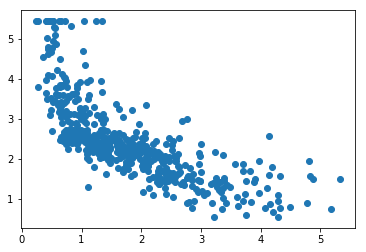

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

x, y = load_boston(return_X_y=True)

#select one column for simplicity. 
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

plt.scatter(x, y)

In [7]:
# model variables
w = Variable(torch.zeros(1), requires_grad=True)
b = Variable(torch.zeros(1), requires_grad=True)

# data variables
x = Variable(torch.from_numpy(x)).type(torch.FloatTensor)
y = Variable(torch.from_numpy(y)).type(torch.FloatTensor)


# обратите внимание, w и b -- это leaf variables
# x и y -- нет
# .type(...) возвращает новую Variable

for vv in [w, b, x, y]:
    print(vv.is_leaf)

True
True
False
False


In [8]:
#try out gradients
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

loss.backward()

#now w.grad is a Variable containing gradient of L w.r.t. w

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

# no gradients for non-leaf variables
print("Non-Leaf x dL/dx = \n", x.grad)
print("Non-Leaf loss dL/dpred = \n", y_pred.grad)

dL/dw = 
 Variable containing:
-7.2240
[torch.FloatTensor of size 1]

dL/db = 
 Variable containing:
-4.9048
[torch.FloatTensor of size 1]

Non-Leaf x dL/dx = 
 None
Non-Leaf loss dL/dpred = 
 None


## Градиенты промежуточных вершин

В графе, который мы описали `x` и `y_pread` не являются листовыми вершинами. По умолчанию для них не сохраняются градиенты.

Для промежуточных вершин мы можем запросить сохранение градиентов с помощью функции `.retain_grad()`.

Обратите внимание, что `x` оказалась не листовой из-за преобразования типов (это тоже операция в графе):
    
```
x = Variable(torch.from_numpy(x)).type(torch.FloatTensor) 
vs
x = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True)
```


In [9]:
y_pred = w * x + b

# check this:
y_pred.retain_grad()

loss = torch.mean((y_pred - y)**2)
loss.backward()

print("Non-Leaf loss dL/dpred = \n", y_pred.grad[:10])

Non-Leaf loss dL/dpred = 
 Variable containing:
1.00000e-02 *
 -1.0325
 -0.9292
 -1.4928
 -1.4368
 -1.5573
 -1.2346
 -0.9851
 -1.1658
 -0.7098
 -0.8131
[torch.FloatTensor of size 10]



# Линейная регрессия

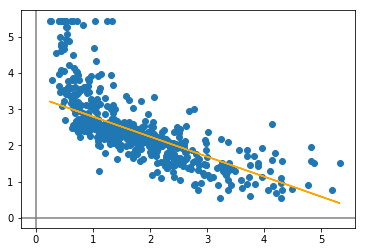

loss =  0.497132
Done!


In [10]:
from IPython.display import clear_output

for i in range(100):
    
    #compute loss
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y)**2)
    
    # backprop
    loss.backward()
    
    # gradient descent step for weights
    # take alpha about 0.1
    w.data -= 0.1*w.grad.data
    b.data -= 0.1*b.grad.data
    
    #zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    #the rest of code is just bells and whistles
    if (i + 1) % 5==0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.data.numpy(),y.data.numpy())
        plt.plot(x.data.numpy(),y_pred.data.numpy(),color='orange')
        plt.show()

        print("loss = ", loss.data.numpy()[0])
        if loss.data.numpy()[0] < 0.5:
            print("Done!")
            break

# Optimizers

В этом примере мы пользовались простым правилом для градиентного спуска:
  
$$\theta^{n+1} = \theta^{n} - \alpha \nabla_{\theta}L$$


Единственным параметром в нем является $\alpha$ -- это `learning_rate`.

На практике часто используют различные модификации (например _Momentum_):

$$\theta^{n+1} = \theta^{n} - U^{n}\\
U^{n} = \gamma U^{n-1} + \alpha \nabla_{\theta}(L)
$$

Хороший обзор алгоритмов оптимизации для сетей можно посмотреть [тут](http://ruder.io/optimizing-gradient-descent/).



Pytorch предоставляет практически все широкораспространненные оптимизаторы:    
http://pytorch.org/docs/master/optim.html




Оптимизаторы удобны в использовании:

- требуется указать список переменных для оптимизации
- `opt.step()` применяет `update` ($U^{n}$) к весам
- `opt.zero_grad()` сбрасывает градиенты





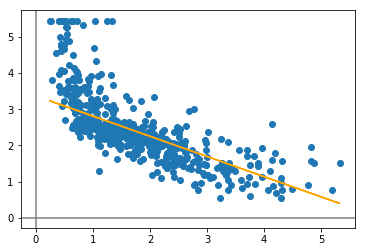

loss =  0.493518
Done!


In [11]:
# get data
x, y = load_boston(return_X_y=True)
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

# data variables
x = Variable(torch.from_numpy(x)).type(torch.FloatTensor)
y = Variable(torch.from_numpy(y)).type(torch.FloatTensor)

# model variables
w = Variable(torch.zeros(1), requires_grad=True)
b = Variable(torch.zeros(1), requires_grad=True)

# define optimizer
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(100):
    # compute loss
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y) ** 2)
    
    
    # backprop and gradient descent
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    #the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.data.numpy()[0])
        if loss.data.numpy()[0] < 0.5:
            print("Done!")
            break

## Highlevel-API 

При работе с нейронными сетями становится неудобно контролировать переменные с весами по-отдельности. Pytorch предоставляет высокоуровневый API для моделей http://pytorch.org/docs/master/nn.html#torch.nn.Module.


Чтобы воспользоваться моделью необходимо отнаследоваться от torch.nn.Module, определить слои и описать `forward`, `backward` будет вычислен автоматически.


Для демонстрации снова воспользуемся MNIST'ом.

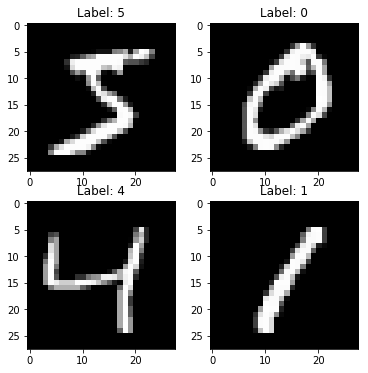

In [12]:
# MNIST again
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [22]:
# Higher-level API:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hidden_size=40):
        super(Net, self).__init__()
        # here you construct weights for layers
        self.fc1 = nn.Linear(X_train.shape[1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        # here you describe usage of layers
        #print('forward')
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # check log_softmax signature
        return F.log_softmax(x, dim=-1)
    # backward function computes automaticaly


In [92]:
#МОЙ БЛОК
#model = Net()
#tt = Variable(torch.from_numpy(X_train[:10, :].astype(np.float32)))
#output = model(tt)

In [15]:
#output

In [16]:
# model interface:
model = Net()
tt = Variable(torch.from_numpy(X_train[:10, :].astype(np.float32)))
output = model(tt)

print('Model outputs: \n', output.data)
# TODO: получите вероятности из ouput c помощью функций из torch
# hint: см документацию к log_softmax
probs = torch.exp(output)
print('Probs: \n', probs.data)

# TODO: получите предсказание из output c помощью функций из torch
_, pred = torch.max(probs, dim=1)
print('Pred: \n', pred.data.numpy())
print('Truth: \n', y_train[:10])

forward
Model outputs: 
 
-2.3341 -2.2379 -2.3910 -2.4255 -2.2461 -2.3177 -2.2621 -2.2662 -2.2098 -2.3582
-2.3585 -2.2204 -2.3581 -2.4266 -2.2230 -2.3451 -2.2525 -2.2955 -2.2087 -2.3633
-2.3705 -2.2584 -2.3638 -2.4621 -2.2006 -2.3133 -2.2564 -2.2514 -2.2096 -2.3716
-2.3472 -2.2889 -2.3664 -2.4414 -2.2195 -2.2881 -2.2748 -2.2441 -2.2186 -2.3602
-2.3634 -2.2733 -2.3749 -2.4476 -2.2158 -2.3226 -2.2551 -2.2470 -2.1966 -2.3585
-2.3487 -2.2325 -2.3586 -2.4895 -2.1969 -2.3441 -2.2943 -2.2792 -2.1924 -2.3248
-2.3462 -2.2565 -2.3621 -2.4403 -2.2354 -2.3212 -2.2580 -2.2694 -2.2015 -2.3588
-2.2632 -2.2394 -2.3988 -2.4202 -2.2972 -2.3588 -2.3101 -2.3189 -2.1746 -2.2693
-2.3667 -2.2534 -2.3627 -2.4350 -2.2281 -2.3196 -2.2415 -2.2552 -2.2107 -2.3796
-2.3625 -2.2323 -2.3738 -2.4786 -2.2059 -2.3253 -2.2563 -2.2456 -2.2173 -2.3629
[torch.FloatTensor of size 10x10]

Probs: 
 
 0.0969  0.1067  0.0915  0.0884  0.1058  0.0985  0.1041  0.1037  0.1097  0.0946
 0.0946  0.1086  0.0946  0.0883  0.1083  0.0958  

Тренировка сети

Для тренировки сети нам требуется 
- итератор по данным
- функция тренировки (прогон по данным, вычисление и применение градиентов)
- функция валидации (прогон по тестовым данным, вычисление метрик)

In [17]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [97]:
def train(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = Variable(torch.from_numpy(x_batch.astype(np.float32)))
        target = Variable(torch.from_numpy(y_batch.astype(np.int64)))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log


# TODO: написать функцию для валидации по X_val, y_val
# hint: optimizer не нужен
def test(model):
    loss_log = []
    model.eval()

    tt = Variable(torch.from_numpy(X_val.astype(np.float32)))
    target = Variable(torch.from_numpy(y_val.astype(np.int64)))
    output = model.forward(tt)

    probs = torch.exp(output)
    _ , pred = torch.max(probs, dim=1) 

    loss = F.nll_loss(output, target)
    loss_log.append(loss.data[0])
    
    return loss_log

Для отслеживания процедуры тренировки построить график вида
![img](./progress.png)

In [104]:
def plot_history(train_history, val_history, num, title='loss'):
    plt.figure(figsize=(20, 10))
    plt.plot(train_history)
    plt.plot(num * 1600, val_history, '+', markersize=17, markeredgewidth=2)
    plt.xlabel("train steps")
    plt.title("loss at %i epoch" %(num + 1)[-1])
    plt.show()

100%|██████████| 1562/1562 [00:02<00:00, 737.51it/s]


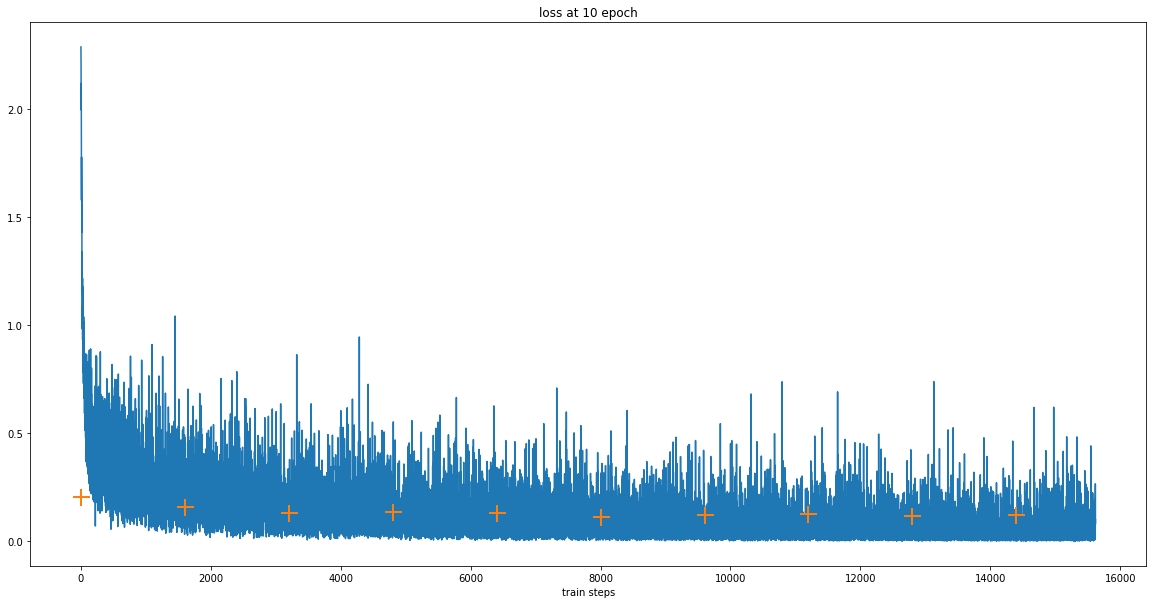

In [106]:
train_log = []
val_log = []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32

range_e = np.arange(0,10)
for epoch in range_e:
    train_loss = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)

    val_loss = np.mean(test(model))
    val_log.append(val_loss)
# TODO: график train_loss vs train_steps с точками val_loss vs trained_steps
# use your plot_history()
# <your code here>
plot_history(train_log,val_log, range_e)

# hint: train_log and val_log may contain data with different shapes

## Метрики

Logloss -- величина, которую трудно интерпретировать. 
Для отслеживания тренировки и сравнения моделей удобнее наблюдать за интерпретируемыми метриками, например точностью (accuracy)

Модифицируйте код train/test функций так, чтобы помимо ошибки подсчитывалась точность за батч:

100%|██████████| 1562/1562 [00:02<00:00, 615.34it/s]


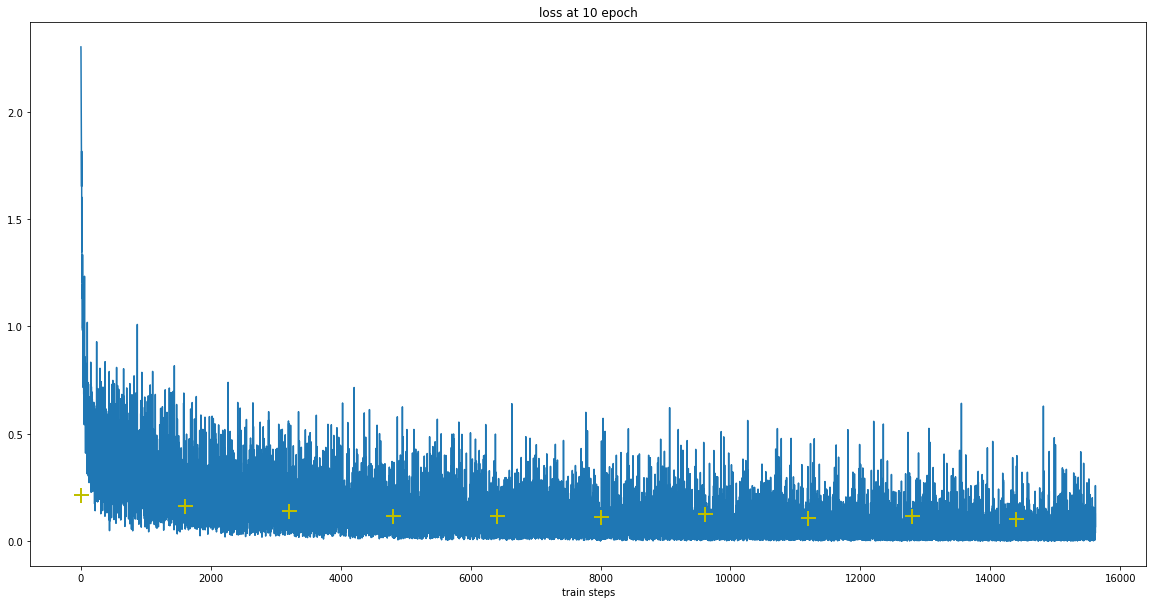

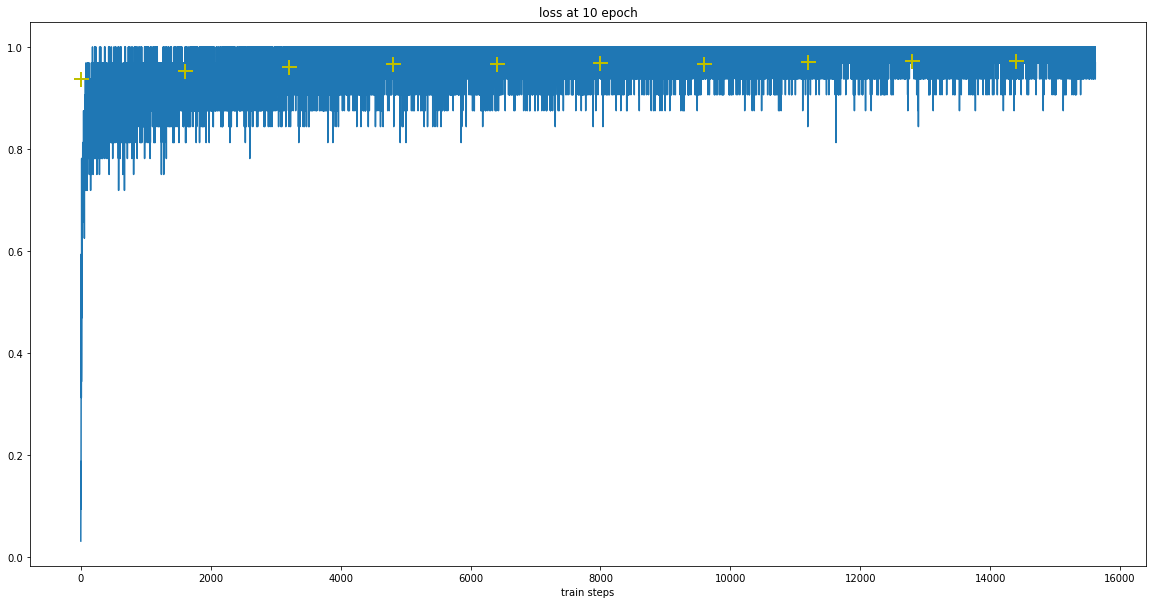

In [46]:
# TODO: добавьте подсчет точности
def train(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = Variable(torch.from_numpy(x_batch.astype(np.float32)))
        target = Variable(torch.from_numpy(y_batch.astype(np.int64)))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        #добавляем вычисление accuracy
        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch) 
        acc_log.append(acc)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.data[0]
        loss_log.append(loss)    
    
    return loss_log, acc_log


# TODO: добавьте подсчет точности:
def test(model):
    loss_log, acc_log = [], []
    model.eval()

    tt = Variable(torch.from_numpy(X_val.astype(np.float32)))
    target = Variable(torch.from_numpy(y_val.astype(np.int64)))
    output = model.forward(tt)

    probs = torch.exp(output)
    _ , pred = torch.max(probs, dim=1)

    loss = F.nll_loss(output, target)
    loss_log.append(loss.data[0])
    
    #добавляем вычисление accuracy
    pred = torch.max(output, 1)[1].data.numpy()
    acc = np.mean(pred == y_val) 
    acc_log.append(acc)
    #
    return loss_log, acc_log


train_log, train_acc_log = [], []
val_log, val_acc_log = [], []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32


range_e = np.arange(0,10)
for epoch in range_e:
    # train
    train_loss, train_acc = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)
    train_acc_log.extend(train_acc)
    
    # test
    val_loss, val_acc = test(model)
    val_loss = np.mean(val_loss)
    val_acc = np.mean(val_acc)

    
    # store metrics
    val_log.append(val_loss)
    val_acc_log.append(val_acc)
    
# plot all metrics (loss and acc for train/val)
plot_history(train_log, val_log, range_e) #сразу построим до конца на одном графике
plot_history(train_acc_log, val_acc_log, range_e)

## Fine Tuning

Потребуется установить пакет `torchvision`:

```
pip install torchvision
```



Для многих прикладных задач не существует больших датасетов с хорошей разметкой. 
Поэтому распространенным приемом является тренировка на похожем, но большом датасете и доучивание сети на целевом.

Такой прием называют **Transfer Learning** или **Finetuning**.

В сверточных сетях для классификации выделяют две части:
- тело сети -- это набор сверток и пулингов (convolutions and poolings)
- голову -- это MLP (набор полносвязных слоев) после которых делается softmax и получаются вероятности разных классов.


Вычислительно простым вариантом finetuning является переучивание головы сети.


Нам потребуется [предобученная модель](http://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets) и датасет для нашей задачи.

Предлагется воспользоваться моделью для ImageNet и датасетом  https://download.pytorch.org/tutorial/hymenoptera_data.zip


В датасете содержатся картинки двух классов (`ants` и `bees`) разных размеров.

In [33]:
# На Windows придется скачать архив по ссылке (~45Mb) и распаковать самостоятельно
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
! unzip ./hymenoptera_data.zip

/bin/sh: wget: command not found
unzip:  cannot find or open ./hymenoptera_data.zip, ./hymenoptera_data.zip.zip or ./hymenoptera_data.zip.ZIP.


Загрузчик данных -- одна из важных компонент для эффективного обучения нейронных сетей:
асинхронная загрузка и быстрая предобработка важны для полного использования GPU.

Для курсовых проектов рекомендуется ознакомиться и использовать [Pytorch Dataset](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

Пример использования:

In [56]:
import torchvision

In [271]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
plt.ion()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


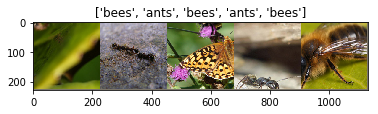

In [272]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [59]:
# обратите внимание на сохранение лучшей версии весов сети
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [60]:
# torchvision содержит ряд моделей с претрейненными весами:
[m for m in dir(models) if not m.startswith('_')]

['AlexNet',
 'DenseNet',
 'Inception3',
 'ResNet',
 'SqueezeNet',
 'VGG',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'inception',
 'inception_v3',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [63]:
model_ft = models.resnet18(pretrained=True)

In [70]:
model_ft.layer4.

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d (256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (downsample): Sequential(
      (0): Conv2d (256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  )
)

In [71]:
for x in model_ft.named_modules():
    print(x[1])

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [73]:
model_ft.fc.out_features = 2

In [74]:
for x in model_ft.named_modules():
    print(x[1])

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [75]:
model_ft = models.resnet18(pretrained=True)
# hint: вы можете изучить устройство любого объекта в python пользуясь интерактивностью интерпретатора и методом dir()

# Список слоев модели можно получить с помощью обхода
# for x in model_ft.named_modules():
#    print(x[0], x[1])

# TODO: подмените в модели последний слой, чтобы она работала для двух классов

model_ft.fc.out_features = 2

# TODO: выберите, какие параметры дообучать. Результат получается лучше если дообучать всё или только последний слой? Почему?
# например, выключить обучение всех параметров можно при помощи этого кода:
# for params in model_ft.parameters():
#     params.requires_grad = False 

#params_to_train = model_ft.fc.parameters()

for params in model_ft.parameters(): 
    params.requires_grad = False 

for params in model_ft.fc.parameters(): 
    params.requires_grad = True 

params_to_train = model_ft.fc.parameters()

# use GPU if you have it
if use_gpu:
    model_ft = model_ft.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Ответ: Поскольку у нас в руках уже есть сеть, которая обучилась классифицировать объекты по классам, то есть она уже обучена на большом и похожем датасете. Значит нам нужно только доучить сеть на нашем датасете (то есть переобучить последний слой).


In [76]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
# если вс сделано правильно, то точность на валидации должна быть больше 94%

Epoch 0/24
----------
train Loss: 0.4256 Acc: 0.5820
val Loss: 0.0855 Acc: 0.9020
Elapsed 0m 54s

Epoch 1/24
----------
train Loss: 0.1670 Acc: 0.7213
val Loss: 0.0644 Acc: 0.9281
Elapsed 1m 45s

Epoch 2/24
----------
train Loss: 0.1744 Acc: 0.7336
val Loss: 0.0861 Acc: 0.9150
Elapsed 2m 38s

Epoch 3/24
----------
train Loss: 0.1322 Acc: 0.7623
val Loss: 0.0602 Acc: 0.9346
Elapsed 3m 30s

Epoch 4/24
----------
train Loss: 0.1243 Acc: 0.7951
val Loss: 0.0705 Acc: 0.9216
Elapsed 4m 28s

Epoch 5/24
----------
train Loss: 0.1621 Acc: 0.7705
val Loss: 0.0687 Acc: 0.9216
Elapsed 5m 26s

Epoch 6/24
----------
train Loss: 0.1117 Acc: 0.8279
val Loss: 0.0761 Acc: 0.9477
Elapsed 6m 25s

Epoch 7/24
----------
train Loss: 0.1017 Acc: 0.8156
val Loss: 0.0555 Acc: 0.9346
Elapsed 7m 17s

Epoch 8/24
----------
train Loss: 0.0858 Acc: 0.8402
val Loss: 0.0583 Acc: 0.9216
Elapsed 9m 47s

Epoch 9/24
----------
train Loss: 0.0992 Acc: 0.8156
val Loss: 0.0579 Acc: 0.9085
Elapsed 12m 46s

Epoch 10/24
-------

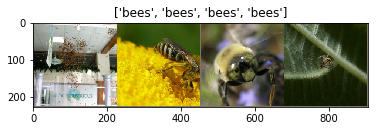

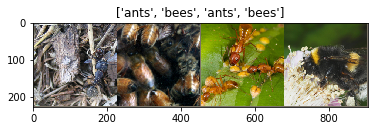

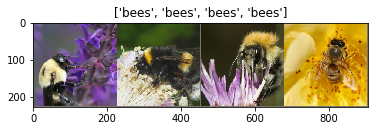

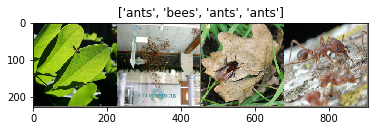

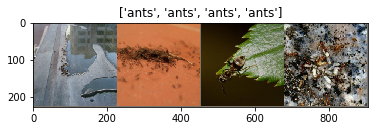

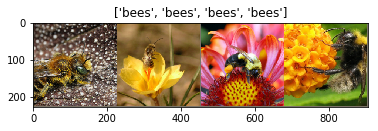

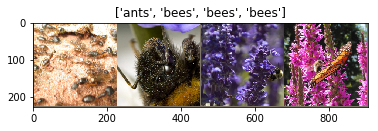

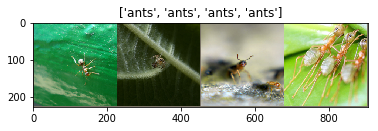

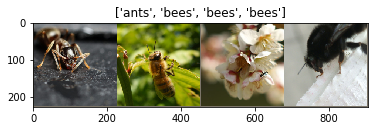

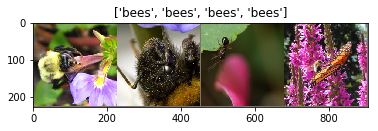

In [193]:
# TODO: напишите функцию, прогоняющую модель на нескольких примерах из валидационной выборки
# Отобразите картинки и предсказания

def visualize(model, num_images=10):
    for i in range(num_images):
        inputs, classes = next(iter(dataloaders['val']))
        out = torchvision.utils.make_grid(inputs)
        
        pred = torch.max(model(Variable(inputs)), dim=1)[1]

        imshow(out, title=[class_names[pred.data[x]] for x in pred.data])
    
            
visualize(model_ft)
#model_ft.forward()

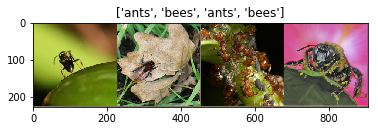

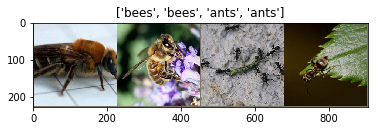

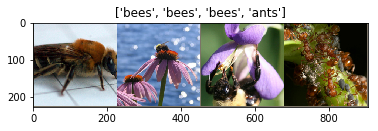

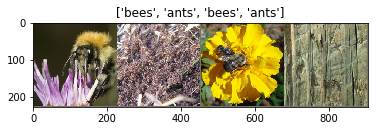

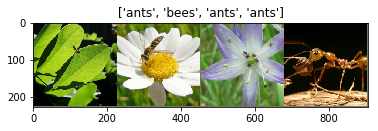

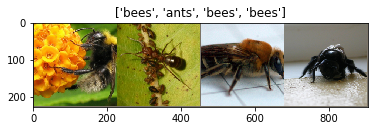

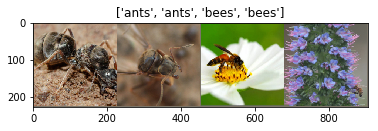

[0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1]
[0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1]


0.9642857142857143

In [270]:
#на всякий случай вручную проверяем что accuracy 0.96

def visualize(model, num_images=5):
    all_classes = np.empty([])
    all_pred = np.empty([])
    for i in range(num_images):
        inputs, classes = next(iter(dataloaders['val']))
        out = torchvision.utils.make_grid(inputs)

        pred = torch.max(model(Variable(inputs)), dim=1)[1]
        
        #imshow(out, title=[class_names[pred.data[x]] for x in pred.data])
        imshow(out, title=[class_names[x] for x in classes])
        #all_classes.append(list(classes))
        
        
        try:
            all_classes = np.concatenate((all_classes, np.array(classes)), axis=0)
            all_pred = np.concatenate((all_pred, pred.data.numpy()), axis=0)
        except ValueError:
            all_classes = np.array(classes)   
            all_pred = pred.data.numpy()

    return all_classes, all_pred
    
all_classes, all_pred = visualize(model_ft, num_images=7)
#model_ft.forward()
print(all_classes)
print(all_pred)

np.mean(all_classes == all_pred)